# **Метод К ближайших соседей (KNN)**

Данный метрический алгоритм используется для классификации объектов или регрессии.

> 


В первом случае объекту присваиваются свойства класса, наиболее распространенного среди k ближайших соседей:


Пусть дана выборка из n объектов двух классов - круги и треугольники. С помощью метода KNN при k = 4 узнаем, какому классу соответствует выбранный обект. Из 4 ближайших соседей большинство являются треугольниками, значит, следуя алгоритму, присвоим объекту свойства второго класса.


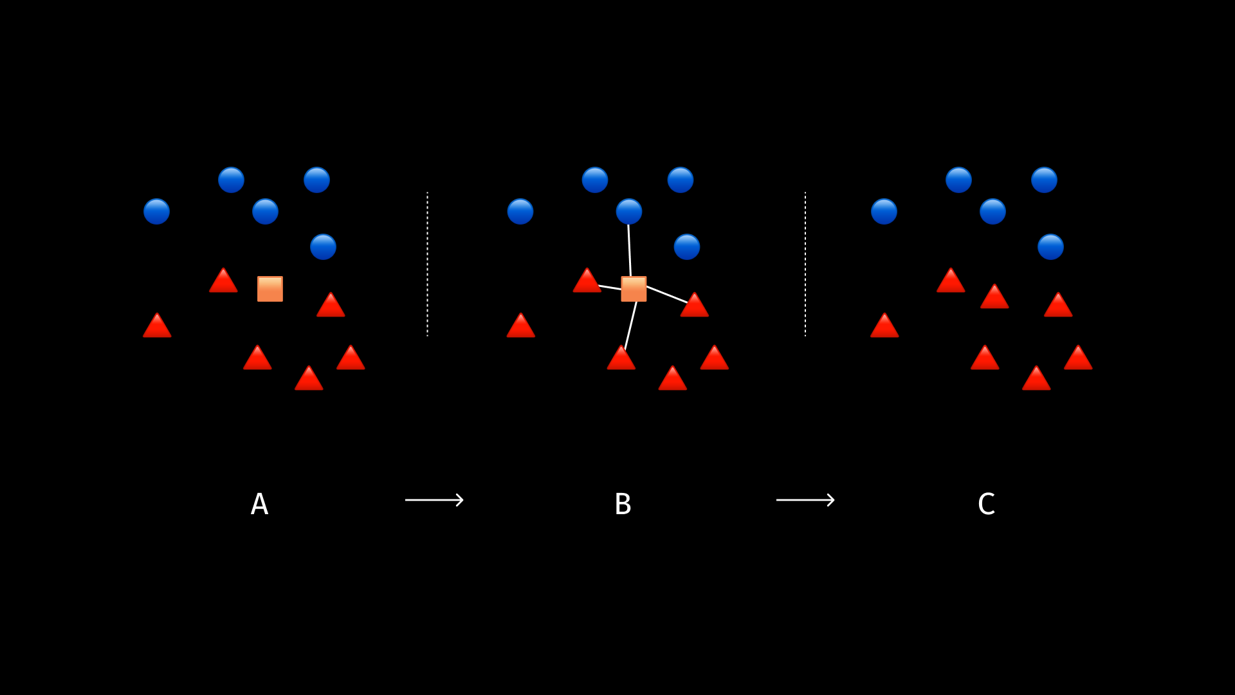



---

# Регрессия
В случае регрессии, построенной на алгоритме, объекту присваивается среднее значение по k ближайшим соседям.
> 
Построим пример при k = 5 для случайной модели:



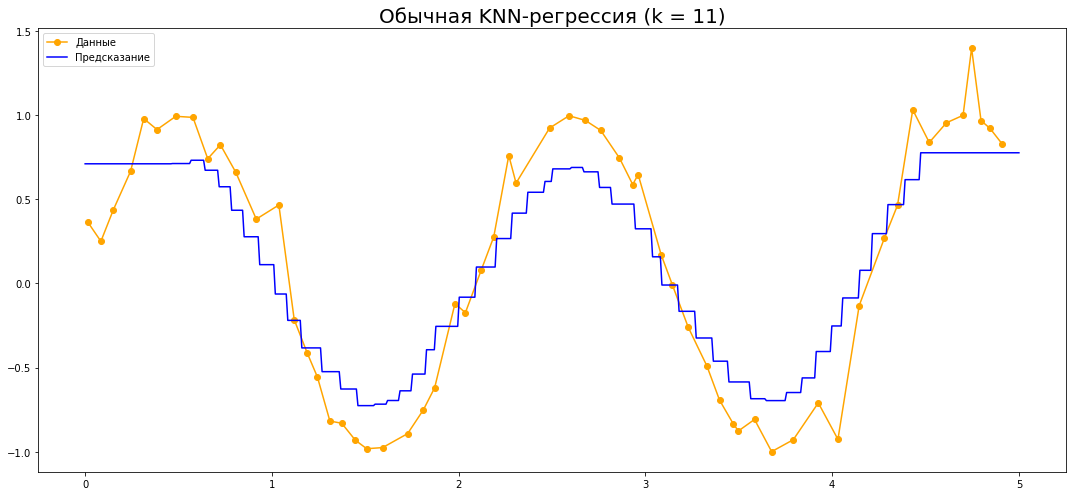

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

#Рассмотрим случайные 60 точек на кривой sin(3x) и шум y0
np.random.seed(0)
X0 = np.sort(5 * np.random.rand(600, 1), axis=0)
X = X0[::10]
Pr = np.linspace(0, 5, 600)[:, np.newaxis]
y0 = np.sin(3*X0).ravel()
y0[::40] += (0.5 - np.random.rand(15)) #Шум
y = y0[::10]

#Нарисуем график предсказания регрессии для k = 11
K = 11

plt.figure(figsize=(15, 7))
knn = KNeighborsRegressor(K)
y_ = knn.fit(X, y).predict(Pr)


plt.plot(X, y, 'o-',color='orange', label='Данные')
plt.plot(Pr, y_, color='blue', label='Предсказание')
plt.axis('tight')
plt.legend()
plt.title("Обычная KNN-регрессия (k = %i)"%K, fontsize=20)

plt.tight_layout()
plt.show()

В данной модели каждой точке соответствует среднее значение по её 5 соседям в двумерном пространстве:
$$ \widehat{y}(x) = \frac{\sum\limits_{i=1}^k y_i(x)}{k} $$

Этот же метод можно использовать для любой размерности пространства и любого его вида, предварительно определив в нем метрику для подсчета расстрояния между точками для вычисления ближайших соседей.

> 
Так для Евклдиового пространства принято брать соответствующую метрику:
$$\rho(X,Y) = (\sum\limits_{i=1}^n(x_i - y_i)^2)^{\frac{1}{2}}$$

![](https://drive.google.com/uc?export=view&id=18vQPiJWxxZdvXjYCCP-IpRA_cGH9uPoJ)
>
А для поверхности шара используется формула Хаверсина:
$$\rho(X,Y) = 2arcsin\big{[}(sin^2(\frac{x_1 - y_1}{2}) + cos(x_1)cos(y_1)sin^2(\frac{x_2 - y_2}{2}))^{\frac{1}{2}}\big{]}$$

![](https://drive.google.com/uc?export=view&id=1Z2t4P5-LC5O2S6j7gu1XMFCIHRAMla1-)



Однако данная модель не всегда подходит для предсказания среднего значения.


---


>
Рассмотрим пример:
>

>


Пусть даны высоты некоторых точек на карте, постараемся предсказать высоту отмеченной точки 

при помощи алгоритма для k = 3, 4 и 5.

> 


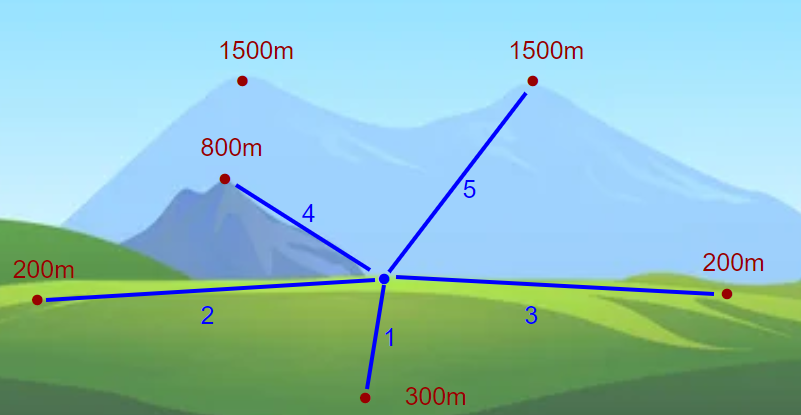

$$ При\quad k = 3⟼ y\approx233$$
$$ При\quad k = 4⟼ y=375$$
$$ При\quad k = 5⟼ y=600$$
Заметно, что увеличение k не добавляет точность предсказания, а наоборот сильно ухудшает его. В данном примере четко видно, что для верного предсказания высоты местности дальние вершины не играют особой роли, а поэтому учитывать их значение на равне с ближними некорректно. Чтобы решить эту проблему добавим каждой точке ее "коэффициент важности" или, иначе говоря, *вес*. Такой алгоритм называется *взвешенным KNN*.



---
# Взвешенная регрессия

Для более точного предсказания будем учитывать расстояние от нашей точки до соседних. То есть если точка находится далеко, то для предсказания вклад будет маленьким, а если близко - большим. Тогда мы можем записать следующую формулу:
$$\widehat{y}(X) = \frac{\sum\limits_{i=1}^k w_i y_i}{\sum\limits_{i=1}^k w_i} = \frac{\sum\limits_{i=1}^k K(\frac{\rho(X, x_i)}{h}) y_i}{\sum\limits_{i=1}^k K(\frac{\rho(X, x_i)}{h})}$$
Функция K - ядро регрессии - как раз таки говорит нам, насколько важен конкретный объект из выборки для предсказания в анализируемой точке, а h - ширина окна. Ширина окна сильно влияет как раз на качество модели. При слишком маленькой ширине модель сильно подстраивается под обучающую выборку и теряет свою обобщающую способность. При слишком большой ширине, напротив, модель становится слишком простой. Универсальной ширины окна не существует, поэтому для каждой задачи её приходится подбирать отдельно.

>

Последняя формула называется формулой Надарая — Ватсона, она является одним из непараметрических методов восстановления регрессии, объединённых названием ядерная регрессия (kernel regression).

# Для сравнения применим формулы обычной модели, "с весом" и с гауссовским ядром $K(\rho)=e^{-2\rho^2}$ к обычной модели $y=sin(3x)$.

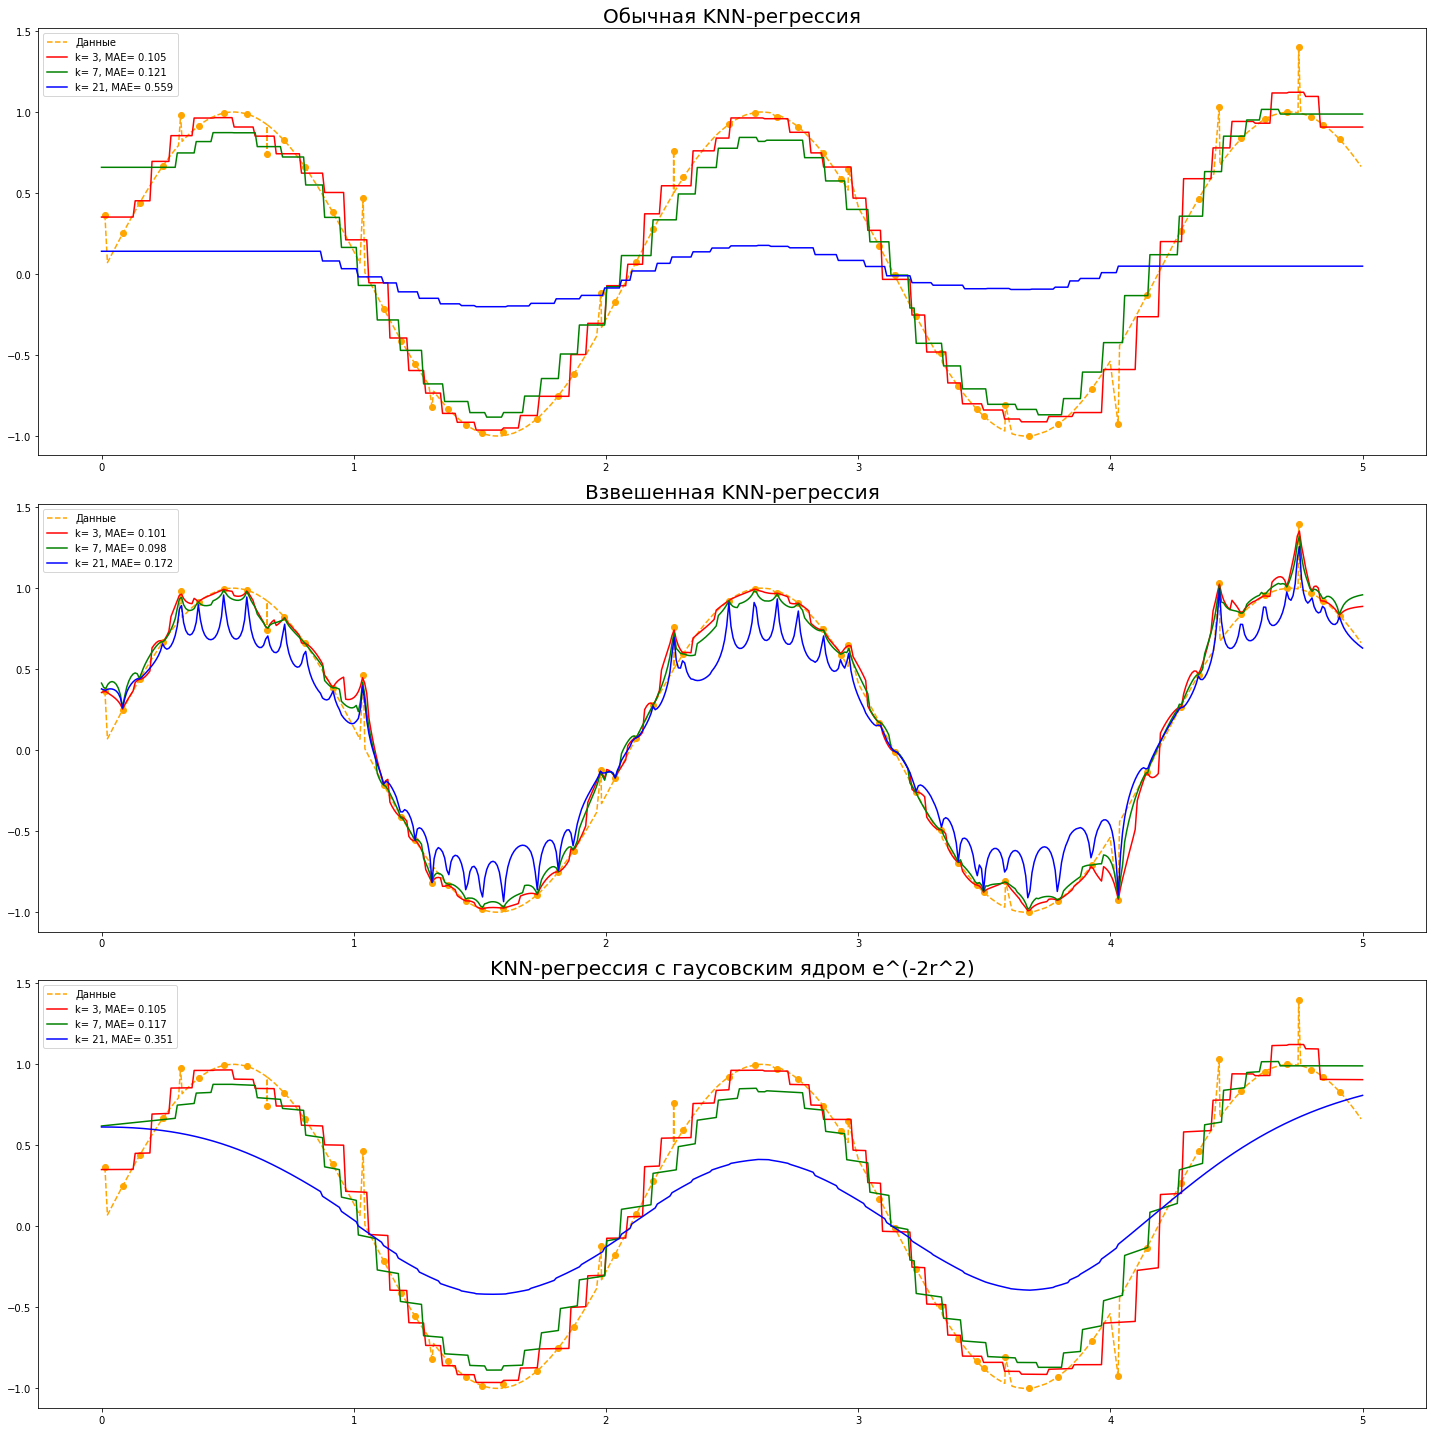

In [3]:
from types import ModuleType
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import time

#Определим гауссово ядро
def Gauss(distance):
  weights = distance
  weights = weights**2
  weights *= (-2)
  weights = np.exp(weights)
  return weights

#Рассмотрим случайные 60 точек на кривой sin(3x) и шум y0
np.random.seed(0)
X0 = np.sort(5 * np.random.rand(600, 1), axis=0)
X = X0[::10]
Pr = np.linspace(0, 5, 600)[:, np.newaxis]
y0 = np.sin(3*X0).ravel()
y0[::40] += (0.5 - np.random.rand(15)) #Шум
y = y0[::10]

#нарисуем графики для обычной, взвешенной и ядерной регрессий
K = [3, 7, 21]
colork = ['red', 'green', 'blue']

plt.figure(figsize=(20, 20))
for i, mode in enumerate(['uniform', 'distance', Gauss]):
  plt.subplot(3, 1, i + 1)
  plt.plot(X0, y0, '--', color='orange', label='Данные')
  plt.plot(X, y, 'o', color='orange')

  for j in range(3):
    knn = KNeighborsRegressor(K[j], weights = mode)
    y_ = knn.fit(X, y).predict(Pr)
    plt.plot(Pr, y_, color=colork[j], label="k= %d, MAE= %.3f"%(K[j], mean_absolute_error(y_, y0)))
    
  plt.axis('tight')
  plt.legend()

  if mode == 'uniform':
    plt.title("Обычная KNN-регрессия", fontsize=20)
  if mode == 'distance':
    plt.title("Взвешенная KNN-регрессия", fontsize=20)
  if mode == Gauss:
    plt.title("KNN-регрессия с гаусовским ядром e^(-2r^2)", fontsize=20)  
plt.tight_layout()
plt.show()

#Для подсчета MAE сравниваются значения в 500 точках, из которых только по 50 строится предсказание.

Для сравнения посмотрим на показатели среднеквадратичного отклонения MAE и времени работы алгоритма 

для каждого $k\in[1, 40]$.

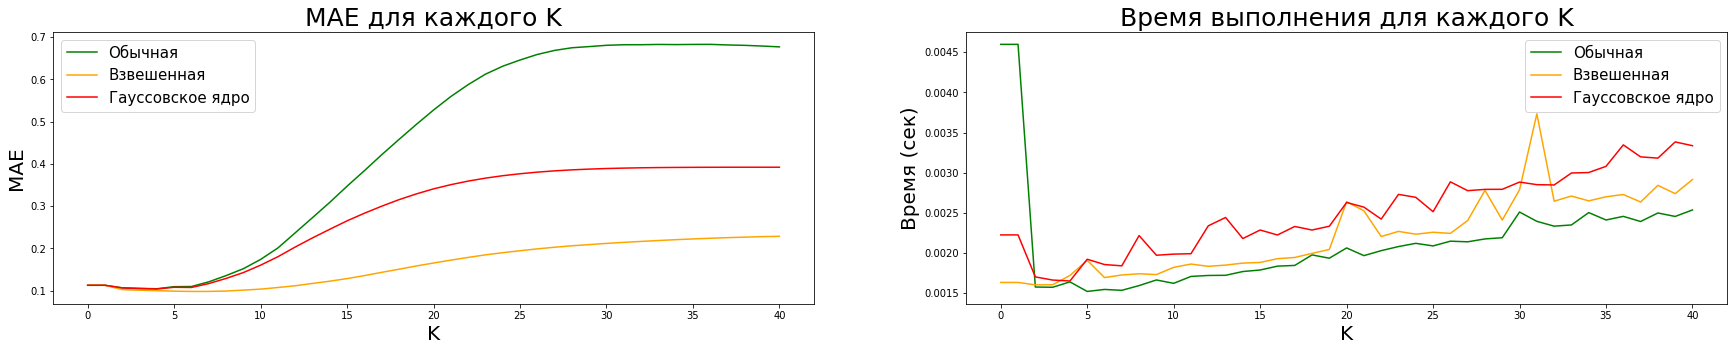

In [ ]:
#Создадим массивы значений MAE и времени вычислений для каждой регрессии
MAE1_st = []; Time1_st = []
MAE1_w  = []; Time1_w  = []
MAE1_gs = []; Time1_gs = []

Time1 = [Time1_st, Time1_w, Time1_gs]
MAE1 = [MAE1_st, MAE1_w, MAE1_gs] 

#Нарисуем графики MAE и времени вычислений для каждого значения k (от 0 до 40)
for i, mode in enumerate(['uniform', 'distance', Gauss]):
  for k in range(1, 41):

    start_time = datetime.now() #Время

    model_knn = KNeighborsRegressor(n_neighbors = k, weights = mode).fit(X, y)
    prediction_knn = model_knn.predict(Pr)
    MAE1[i].append(mean_absolute_error(y0, prediction_knn))
    Time_work = (datetime.now() - start_time).total_seconds()
    Time1[i].append(Time_work)
    if k==1:
      MAE1[i].append(mean_absolute_error(y0, prediction_knn))
      Time1[i].append(Time_work)

plt.figure(figsize=(30,5))
plt.subplot(1, 2, 1)

plt.plot(MAE1[0], color='green', label='Обычная')
plt.plot(MAE1[1], color='orange', label='Взвешенная')
plt.plot(MAE1[2], color='red', label='Гауссовское ядро')
plt.legend(fontsize = 15)
plt.xlabel('K', fontsize = 20)
plt.ylabel('MAE', fontsize = 20)
plt.title('MAE для каждого K', fontsize = 25)

plt.subplot(1, 2, 2)

plt.plot(Time1[0], color='green', label='Обычная')
plt.plot(Time1[1], color='orange', label='Взвешенная')
plt.plot(Time1[2], color='red', label='Гауссовское ядро')
plt.legend(fontsize = 15)
plt.xlabel('K', fontsize= 20)
plt.ylabel('Время (сек)', fontsize = 20)
plt.title('Время выполнения для каждого K', fontsize = 25)

plt.show()

Проанализировав результаты можно сделать вывод, что проноз взвешенной регрессии для данной модели при всех k лучше, а модель с ядром Гаусса ведет себя близко к обычной knn регрессии. Особенно вблизи данных точек.

Показатели времени не столь велики, чтобы отражать действительную разницу между алгоритмами, но можно предположить, что обычная регрессия самая быстрая, в то время как для регрессии с ядром Гаусса времени требуется больше всех при каждом k. Заметим, что с ростом k время выполнения растёт линейно, т.к. растёт количество операций подсчета растет соответственно.



# Проведём второй эксперимент:

Рассмотрим базу данных Delivery club и постараемся предсказать количество продаж методом KNN-регрессии.

Для начала приведем графики MAE и времени работы для каждого типа регрессии, а затем, выбрав k с наименьшим MAE для каждой, продемонстрирем предсказания с наименьшими отклонениями.

In [ ]:
import pandas as pd
data = pd.read_csv("DC_Data.csv")
data = data.sort_values(by=['date'])

#Очистим ненужные данные: id, date, city_name
data = data.drop(['city_name', 'id','weather_desc','pressure', 'date'], axis=1)

data.head()

,store_id,category_id,product_id,price,humidity,temperature,sales
0,1,1,1,4.79,61.9375,23.1875,26
486761,113,1,1,4.79,57.5000,14.8125,6
64160,15,1,20,3.51,77.3750,19.3750,1
486961,113,2,2,7.78,57.5000,14.8125,3
487161,113,1,4,8.15,57.5000,14.8125,2


In [ ]:
#Стандартизируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data.drop('sales', axis=1))
scaled_features = scaler.transform(data.drop('sales', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = data.drop('sales', axis=1).columns)

#Создаем train / test выборки

from sklearn.model_selection import train_test_split

x = scaled_data
y = data['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, shuffle=False)

MAE2_st = []; Time2_st = []
MAE2_w  = []; Time2_w  = []
MAE2_gs = []; Time2_gs = []

#MAE для обычной регрессии
for k in range(1, 51):

  start_time = datetime.now() #Время

  model_knn_st = KNeighborsRegressor(n_neighbors = k).fit(x_train, y_train)
  prediction_knn_st = model_knn_st.predict(x_test)
  MAE2_st.append(mean_absolute_error(y_test, prediction_knn_st))
  Time_work = (datetime.now() - start_time).total_seconds()
  Time2_st.append(Time_work)
  if k==1:
    MAE2_st.append(mean_absolute_error(y_test, prediction_knn_st))
    Time2_st.append(Time_work)

#MAE для взвешенной регрессии
for k in range(1, 51):
  start_time = datetime.now() #Время

  model_knn_w = KNeighborsRegressor(n_neighbors = k, weights = 'distance').fit(x_train, y_train)
  prediction_knn_w = model_knn_w.predict(x_test)
  MAE2_w.append(mean_absolute_error(y_test, prediction_knn_w))
  Time_work = (datetime.now() - start_time).total_seconds()
  Time2_w.append(Time_work)
  if k==1:
    MAE2_w.append(mean_absolute_error(y_test, prediction_knn_w))
    Time2_w.append(Time_work)

#MAE для регрессии с Гауссовским ядром
for k in range(1, 51):
  start_time = datetime.now() #Время

  model_knn_gs = KNeighborsRegressor(n_neighbors = k, weights = Gauss).fit(x_train, y_train)
  prediction_knn_gs = model_knn_gs.predict(x_test)
  MAE2_gs.append(mean_absolute_error(y_test, prediction_knn_gs))
  Time_work = (datetime.now() - start_time).total_seconds()
  Time2_gs.append(Time_work)
  if k==1:
    MAE2_gs.append(mean_absolute_error(y_test, prediction_knn_gs))
    Time2_gs.append(Time_work)

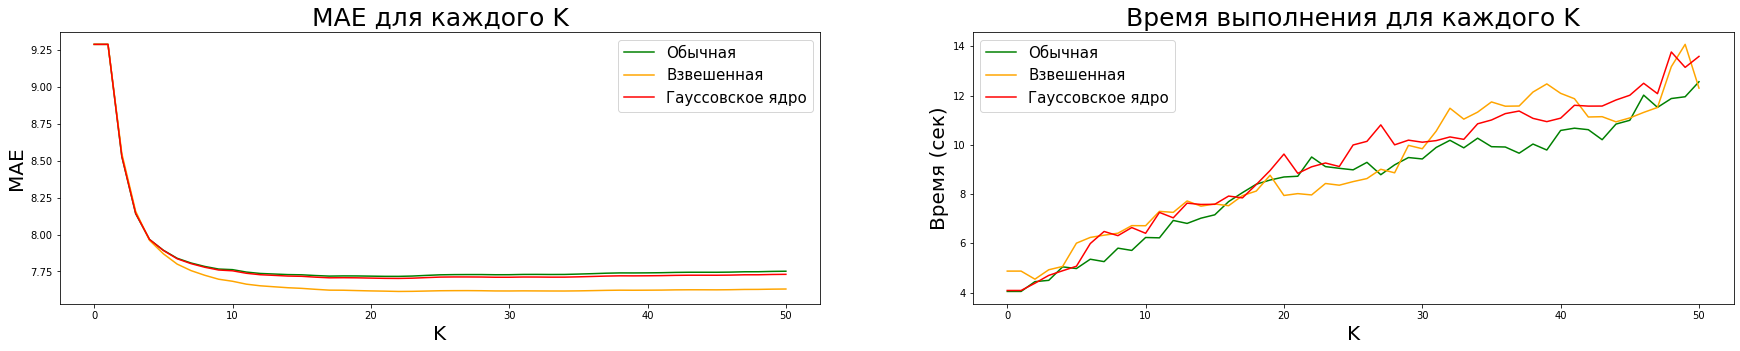

In [ ]:
#Нарисуем графики MAE и времени вычислений для каждого значения k (от 0 до 50)
plt.figure(figsize=(30,5))
plt.subplot(1, 2, 1)

plt.plot(MAE2_st, color='green', label='Обычная')
plt.plot(MAE2_w, color='orange', label='Взвешенная')
plt.plot(MAE2_gs, color='red', label='Гауссовское ядро')
plt.legend(fontsize = 15)
plt.xlabel('K', fontsize = 20)
plt.ylabel('MAE', fontsize = 20)
plt.title('MAE для каждого K', fontsize = 25)

plt.subplot(1, 2, 2)

plt.plot(Time2_st, color='green', label='Обычная')
plt.plot(Time2_w, color='orange', label='Взвешенная')
plt.plot(Time2_gs, color='red', label='Гауссовское ядро')
plt.legend(fontsize = 15)
plt.xlabel('K', fontsize= 20)
plt.ylabel('Время (сек)', fontsize = 20)
plt.title('Время выполнения для каждого K', fontsize = 25)

plt.show()

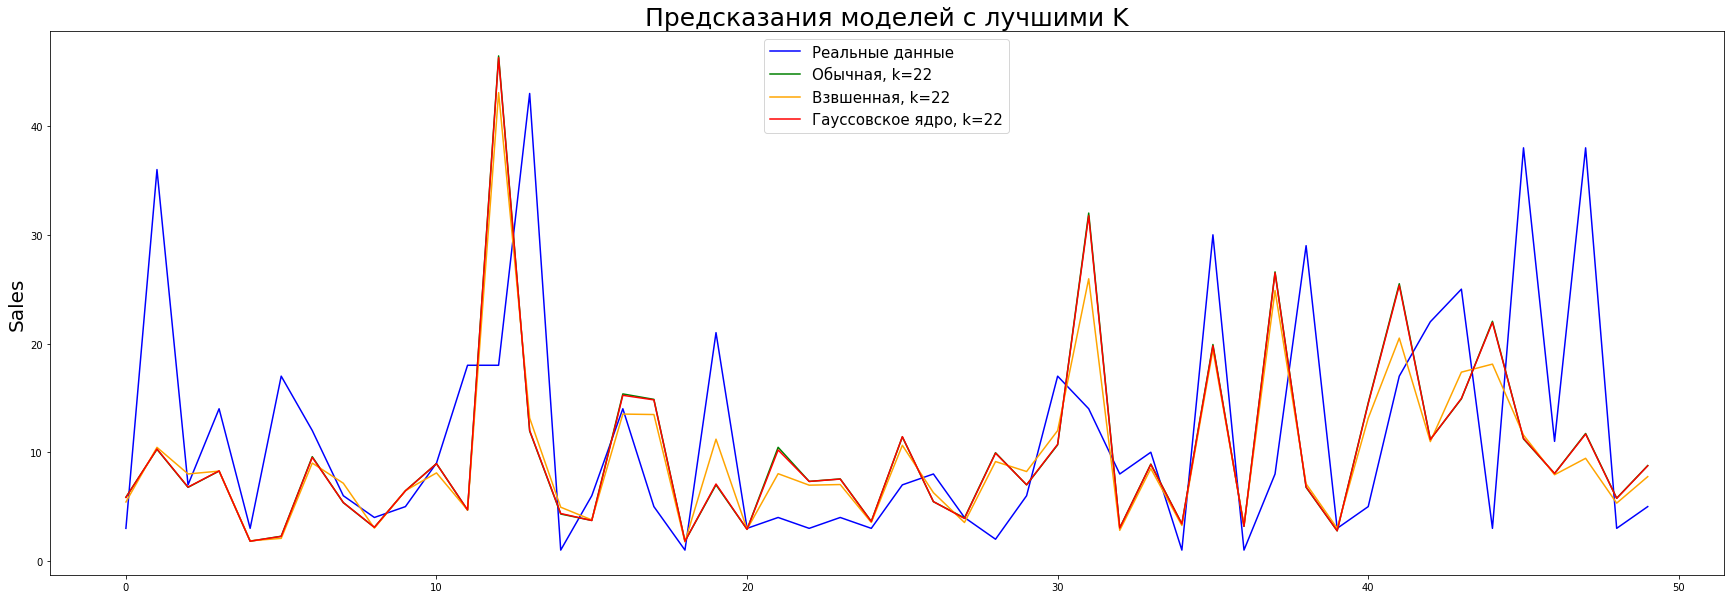

In [ ]:
#Построим предсказания по каждому виду регрессий
model_knn_st = KNeighborsRegressor(n_neighbors = np.argmin(MAE2_st)).fit(x_train, y_train)
prediction_knn_st = list(model_knn_st.predict(x_test))

model_knn_w = KNeighborsRegressor(n_neighbors = np.argmin(MAE2_w), weights = 'distance').fit(x_train, y_train)
prediction_knn_w = list(model_knn_w.predict(x_test))

model_knn_kw = KNeighborsRegressor(n_neighbors = np.argmin(MAE2_gs), weights = Gauss).fit(x_train, y_train)
prediction_knn_kw = list(model_knn_kw.predict(x_test))

y_test = list(y_test)

plt.figure(figsize=(30,10))
plt.plot(y_test[1:51], color='blue', label='Реальные данные')
plt.plot(prediction_knn_st[1:51], color='green', label='Обычная, k=%d'%np.argmin(MAE2_st))
plt.plot(prediction_knn_w[1:51], color='orange', label='Взвшенная, k=%d'%np.argmin(MAE2_w))
plt.plot(prediction_knn_kw[1:51], color='red', label='Гауссовское ядро, k=%d'%np.argmin(MAE2_gs))
plt.legend(loc='upper center', fontsize = 15)
plt.title('Предсказания моделей c лучшими K', fontsize = 25)
plt.ylabel('Sales', fontsize = 20)
plt.show()

# Итог

Изучив два примера можно сделать вывод, что взвешенная регрессия выигрывает во многих лучаях. Главное, что для $k=22$ с нимимальным MAE взвешенная регрессия показывает самое быстрое время, значительно отрываясь от других. 

Регрессия с ядром Гаусса показала себя лучше обычной по параметру MAE, но не столь существенно. При этом времени на выполнение в среднем она требует больше всех.

Обычная регрессия проигрывает по MAE всем, но в среднем является самой быстрой версией.

Таким образом все варианты использования метода KNN имеют свои достоинства и недостатки.

Все они просты, точны и могут быть использованы как для регрессии, так и для классификации. 

Но в то же время сильно зависят от масштабов выборки и нуждаются в определении "расстояния" между объектами, т.к. если для евклдиового пространства за расстояние можно принять соответствующу метрику, то чтобы определить близкие картины или музыкальные произвдения нужно вводить собственную численную метрику.